In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest

In [2]:
data_wti = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\wti-daily_csv.csv', parse_dates=['Date'])
data_rents = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\Oil rents by country.csv', header=[2])

In [3]:
rents_ecu = data_rents[(data_rents['Country Name'] == 'Ecuador')].T

In [4]:
rents_ecu

,66
Country Name,Ecuador
Country Code,ECU
Indicator Name,Oil rents (% of GDP)
Indicator Code,NY.GDP.PETR.RT.ZS
1960,NaN
...,...
2018,7.166329
2019,6.610501
2020,4.394566
2021,NaN


<AxesSubplot:>

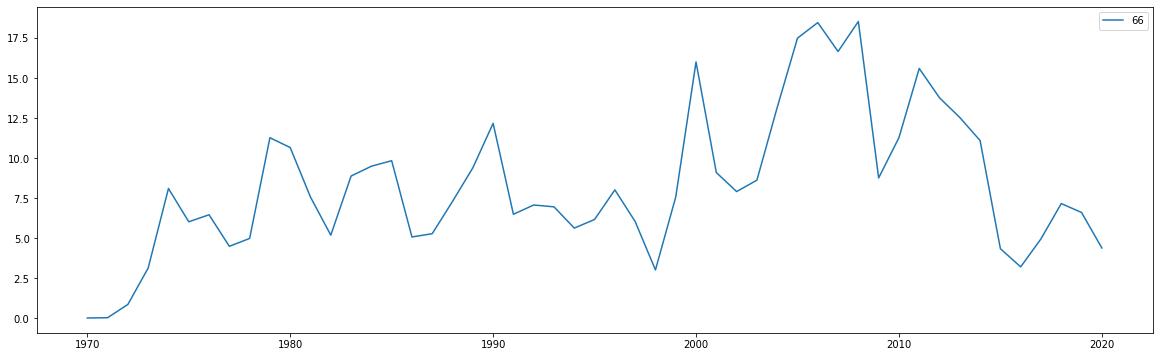

In [5]:
rents_ecu.iloc[14:-2].plot(figsize=(20,6))

In [6]:
data_wti.Date.describe()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16880\1887816428.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_wti.Date.describe()


count                    9232
unique                   9232
top       1986-01-02 00:00:00
freq                        1
first     1986-01-02 00:00:00
last      2022-08-22 00:00:00
Name: Date, dtype: object

In [7]:
data_wti.set_index('Date', inplace=True)

In [8]:
data_wti.head(3)

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53


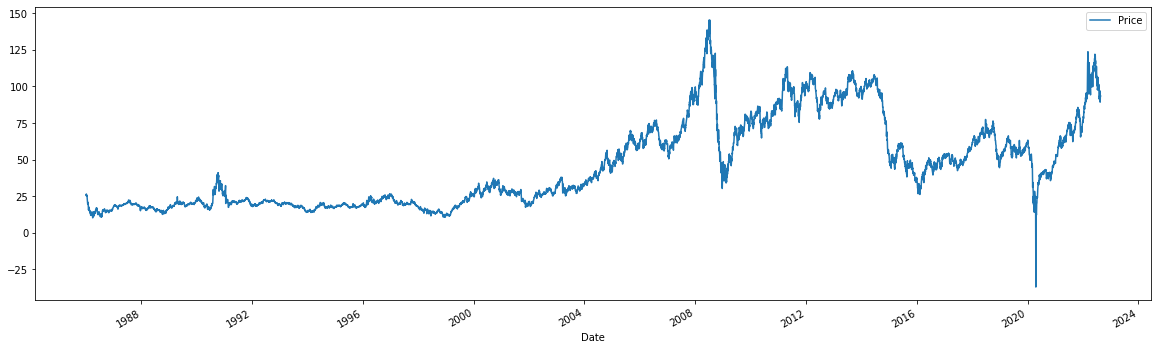

In [9]:
data_wti.plot(figsize=(20,6));

In [104]:
gulf_war = '1990-10-2'
attack_911 = '2001-9-11' 
fina_crisis = '2008-9-25'
peak_before_shale = '2014-6-20'
covid_19 = '2019-12-31'
war_rus_ukr = '2022-03-24'

In [10]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Normal Distribution

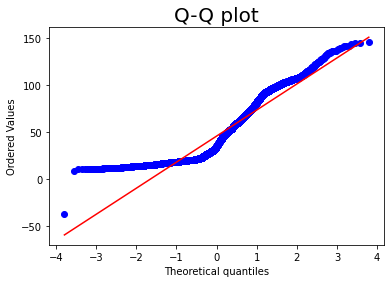

In [11]:
scipy.stats.probplot(data_wti.Price, plot=pylab)
plt.title('Q-Q plot', size=20)
pylab.show() 

In [12]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Stationarity

In [13]:
# Determine p-value to determine if data is stationary
sts.adfuller(data_wti)

(-2.213377714641542,
 0.2014259950861617,
 38,
 9193,
 {'1%': -3.4310615334378807,
  '5%': -2.861854452413968,
  '10%': -2.5669373779569864},
 32747.08402618017)

### Seasonality

In [109]:
price_wti = data_wti.asfreq('B')
price_wti.isnull().sum()

Price    326
dtype: int64

In [110]:
price_wti = price_wti.fillna(value=price_wti.mean())
price_wti = price_wti[war_rus_ukr:]

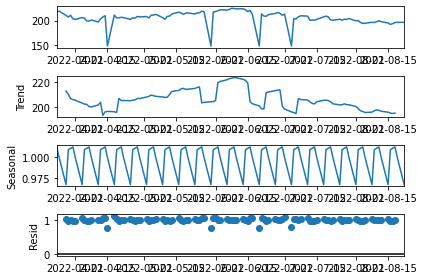

In [112]:
s_dec_multiplicative = seasonal_decompose((price_wti + price_wti.mean()), model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

## Prices

### ACF

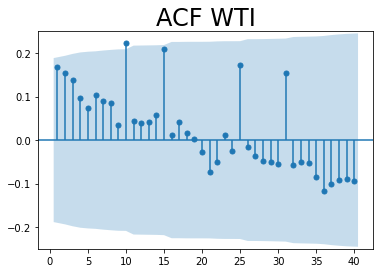

In [114]:
sgt.plot_acf(price_wti, lags=40, zero=False)
plt.title("ACF WTI", size = 24)
plt.ylim(-0.25, 0.25)
plt.show()

### PACF

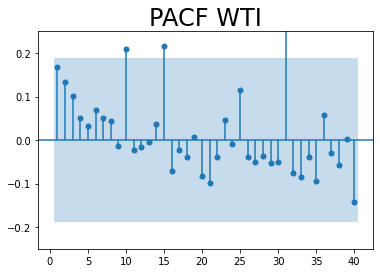

In [138]:
sgt.plot_pacf(price_wti.Price, lags = 40, zero = False, method = ('ols'))
plt.title("PACF WTI", size = 24)
plt.ylim(-0.25,0.25)
plt.show()

### Auto Regresive Modeling

In [118]:
model_ar_15 = ARIMA(price_wti.Price, order=(15,0,0))
results_ar_15 = model_ar_15.fit()
results_ar_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  108
Model:                ARIMA(15, 0, 0)   Log Likelihood                -428.193
Date:                Fri, 23 Sep 2022   AIC                            890.386
Time:                        21:09:26   BIC                            935.982
Sample:                    03-24-2022   HQIC                           908.874
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.0433      7.308     13.963      0.000      87.719     116.367
ar.L1          0.1202      0.119      1.007      0.314      -0.114       0.354
ar.L2          0.1012      0.147      0.688      0.491      -0.187       0.389
ar.L3          0.0799      0.158      0.505      0.614      -0.230       0.390
ar.L4          0.0201      0.181      0.111      0.912      -0.334       0.375
ar.L5         -0.0264      0.200     -0.132      0.895      -0.418       0.365
ar.L6          0.0606      0.152      0.398      0.691      -0.238       0.359
ar.L7          0.0277      0.162      0.170      0.865      -0.291       0.346
ar.L8          0.0191      0.200      0.096      0.924      -0.373       0.412
ar.L9         -0.0374      0.262     -0.143      0.886      -0.550       0.475
ar.L10         0.1945      0.076      2.562      0.010       0.046       0.343
ar.L11        -0.0243      0.359     -0.068      0.946      -0.727       0.679
ar.L12        -0.0299      0.470     -0.064      0.949      -0.951       0.892
ar.L13        -0.0233      0.282     -0.083      0.934      -0.576       0.529
ar.L14         0.0144      0.250      0.057      0.954      -0.476       0.505
ar.L15         0.1911      0.080      2.393      0.017       0.035       0.348
sigma2       160.9751     16.420      9.804      0.000     128.792     193.158
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               814.94
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -3.05
Prob(H) (two-sided):                  0.45   Kurtosis:                        14.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analysing the Residuals

In [119]:
price_wti['p_resid_ar_15'] = results_ar_15.resid

In [139]:
price_wti.p_resid_ar_15.mean(), price_wti.p_resid_ar_15.var()

(-0.24158158414465067, 162.8329961654203)

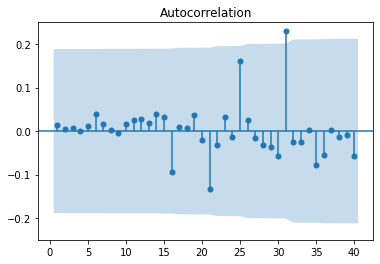

In [140]:
sgt.plot_acf(price_wti.p_resid_ar_15, zero=False, lags=40)
plt.ylim(-0.25,0.25)
plt.show()

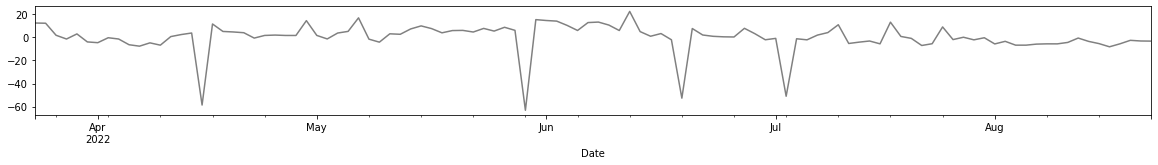

In [142]:
price_wti.p_resid_ar_15.plot(figsize=(20,2), color='grey');

### Auto Regresive Moving Average Modeling

In [143]:
model_ar_15_ma_3 = ARIMA(price_wti.Price, order=(15,0,3))
results_ar_15_ma_3 = model_ar_15_ma_3.fit()
results_ar_15_ma_3.summary()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  108
Model:                ARIMA(15, 0, 3)   Log Likelihood                -427.496
Date:                Fri, 23 Sep 2022   AIC                            894.992
Time:                        21:24:46   BIC                            948.635
Sample:                    03-24-2022   HQIC                           916.742
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.5194      6.927     14.801      0.000      88.943     116.096
ar.L1         -0.6473      0.486     -1.333      0.183      -1.599       0.305
ar.L2         -0.5301      0.443     -1.197      0.231      -1.398       0.338
ar.L3         -0.4157      0.264     -1.577      0.115      -0.932       0.101
ar.L4          0.2687      0.284      0.945      0.345      -0.288       0.826
ar.L5          0.1458      0.243      0.601      0.548      -0.330       0.622
ar.L6          0.1585      0.222      0.715      0.475      -0.276       0.593
ar.L7          0.1112      0.231      0.482      0.630      -0.341       0.563
ar.L8          0.1062      0.273      0.389      0.698      -0.429       0.642
ar.L9          0.0582      0.397      0.147      0.883      -0.720       0.836
ar.L10         0.2263      0.311      0.727      0.467      -0.384       0.836
ar.L11         0.1430      0.402      0.356      0.722      -0.645       0.931
ar.L12         0.0917      0.428      0.214      0.830      -0.747       0.931
ar.L13         0.0751      0.435      0.173      0.863      -0.777       0.927
ar.L14        -0.0665      0.356     -0.187      0.852      -0.763       0.630
ar.L15         0.1200      0.334      0.359      0.719      -0.534       0.774
ma.L1          0.7957      0.529      1.503      0.133      -0.242       1.833
ma.L2          0.7668      0.533      1.439      0.150      -0.277       1.811
ma.L3          0.7248      0.312      2.324      0.020       0.113       1.336
sigma2       159.9203     19.345      8.267      0.000     122.004     197.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               697.23
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -2.88
Prob(H) (two-sided):                  0.42   Kurtosis:                        14.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analysing the Residuals

In [144]:
price_wti['p_resid_ar15_ma3'] = results_ar_15_ma_3.resid

In [145]:
price_wti.p_resid_ar15_ma3.mean(), price_wti.p_resid_ar15_ma3.var(),

(-0.22234215989575434, 160.84772088085026)

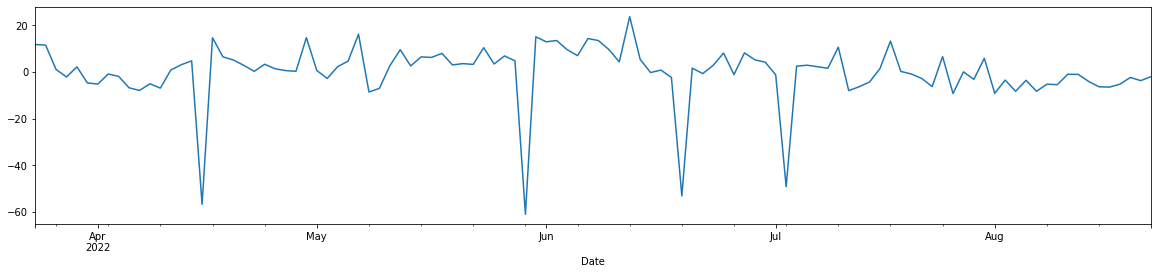

In [146]:
price_wti.p_resid_ar15_ma3.plot(figsize=(20,4));

## Returns

In [147]:
price_wti['p_returns'] = price_wti.Price.pct_change(1).mul(100)
price_wti = price_wti[1:]

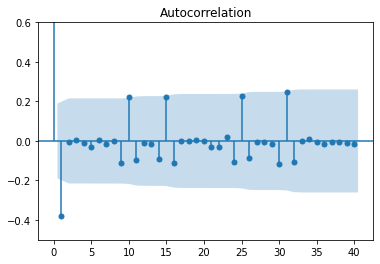

In [152]:
sgt.plot_acf(price_wti.p_returns, lags=40)
plt.ylim(-0.5,0.6)
plt.show()

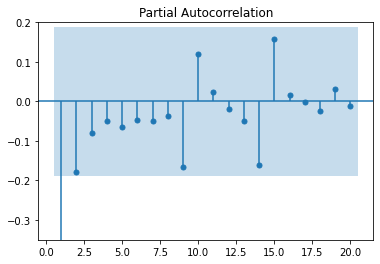

In [155]:
sgt.plot_pacf(price_wti.p_returns, lags = 20, zero = False, method = ('ols'))
plt.ylim(-0.35,0.2)
plt.show()

### Auto Regresive Modeling

In [157]:
model_ret_ar_5 = ARIMA(price_wti.p_returns, order=(5, 0, 0))
results_ret_ar_5 = model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              p_returns   No. Observations:                  107
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -501.656
Date:                Fri, 23 Sep 2022   AIC                           1017.311
Time:                        21:27:16   BIC                           1036.021
Sample:                    03-25-2022   HQIC                          1024.896
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9452      2.485      1.185      0.236      -1.926       7.816
ar.L1         -0.4661      0.078     -5.964      0.000      -0.619      -0.313
ar.L2         -0.2268      0.179     -1.267      0.205      -0.578       0.124
ar.L3         -0.1133      0.338     -0.335      0.737      -0.776       0.549
ar.L4         -0.0764      0.539     -0.142      0.887      -1.133       0.980
ar.L5         -0.0611      0.461     -0.132      0.895      -0.965       0.843
sigma2       689.7965     71.078      9.705      0.000     550.487     829.106
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               414.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             2.07
Prob(H) (two-sided):                  0.60   Kurtosis:                        11.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals of Returns

In [158]:
price_wti['p_ret_resid_ar_5'] = results_ret_ar_5.resid

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16880\564949535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_wti['p_ret_resid_ar_5'] = results_ret_ar_5.resid


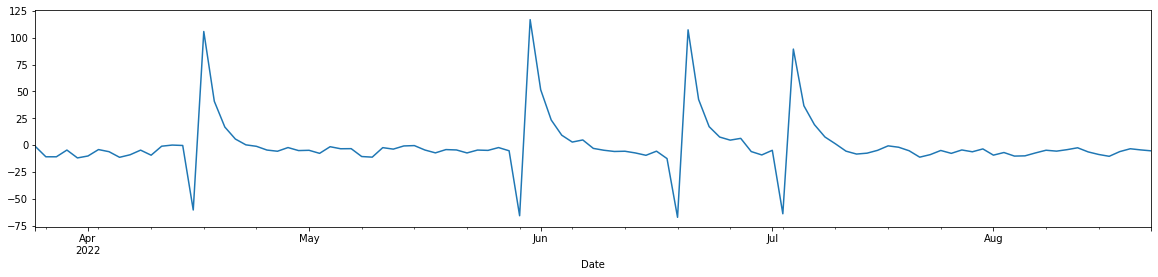

In [159]:
price_wti.p_ret_resid_ar_5.plot(figsize=(20,4));

In [160]:
price_wti.p_ret_resid_ar_5.mean(), price_wti.p_ret_resid_ar_5.var()

(-0.0680857288918021, 696.3687252764386)

### Auto Regresive Moving Average Modeling

In [ ]:
model_ret_ar5_ma5 = ARIMA(price_wti.p_returns, order=(5,0,5))
results_ret_ar5_ma5 = model_ret_ar5_ma5.fit()
results_ret_ar5_ma5.summary()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              p_returns   No. Observations:                  107
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -498.719
Date:                Fri, 23 Sep 2022   AIC                           1021.438
Time:                        21:31:10   BIC                           1053.512
Sample:                    03-25-2022   HQIC                          1034.440
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9489      2.073      1.422      0.155      -1.115       7.013
ar.L1         -1.3657      0.267     -5.123      0.000      -1.888      -0.843
ar.L2         -1.3093      0.465     -2.814      0.005      -2.221      -0.397
ar.L3         -1.2599      0.524     -2.403      0.016      -2.288      -0.232
ar.L4         -0.9235      0.474     -1.949      0.051      -1.853       0.005
ar.L5         -0.0397      0.352     -0.113      0.910      -0.730       0.650
ma.L1          0.9418      0.338      2.788      0.005       0.280       1.604
ma.L2          0.6719      0.450      1.494      0.135      -0.209       1.553
ma.L3          0.6643      0.518      1.281      0.200      -0.352       1.680
ma.L4          0.2730      0.486      0.562      0.574      -0.679       1.225
ma.L5         -0.4634      0.444     -1.043      0.297      -1.335       0.408
sigma2       626.3112    198.977      3.148      0.002     236.323    1016.300
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               420.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             2.16
Prob(H) (two-sided):                  0.28   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Returns vs. Predictions

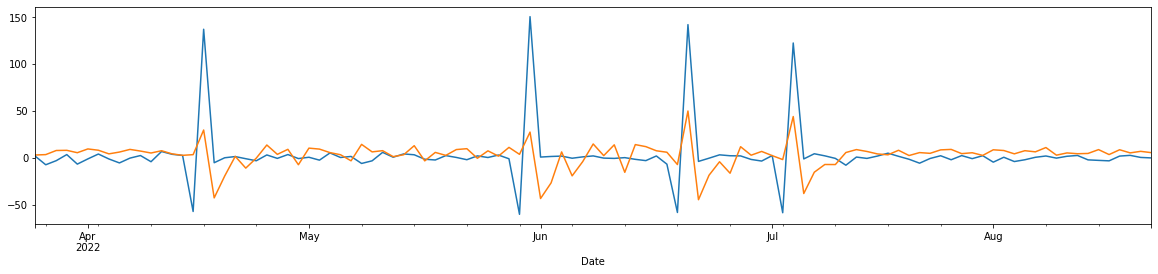

In [167]:
price_wti.p_returns.plot(figsize=(20,4))
results_ret_ar5_ma5.predict().plot(figsize=(20,4))
plt.show()

#### Analyzing ARMA Residuals

In [169]:
price_wti['p_ret_resid_ar5_ma5'] = results_ret_ar5_ma5.resid

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16880\290264532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_wti['p_ret_resid_ar5_ma5'] = results_ret_ar5_ma5.resid


In [170]:
price_wti.p_ret_resid_ar5_ma5.mean(), price_wti.p_ret_resid_ar5_ma5.var()

(-0.09294035170481581, 658.5049862967566)

## Auto-ARIMA Modeling

In [177]:
mod_auar_li = auto_arima(price_wti.Price, m=20, max_p=20, max_q=20, max_P=20, max_Q=20, trend='ct')

In [176]:
results_auar_li = mod_auar_li.fit(price_wti.Price)
results_auar_li.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  107
Model:             SARIMAX(0, 0, [1], 10)   Log Likelihood                -427.862
Date:                    Fri, 23 Sep 2022   AIC                            863.724
Time:                            21:36:18   BIC                            874.415
Sample:                                 0   HQIC                           868.058
                                    - 107                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    106.9473      4.748     22.526      0.000      97.642     116.253
drift         -0.0818      0.077     -1.064      0.287      -0.232       0.069
ma.S.L10       0.2382      0.052      4.568      0.000       0.136       0.340
sigma2       173.1303     14.956     11.576      0.000     143.817     202.444
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):               571.41
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -2.56
Prob(H) (two-sided):                  0.12   Kurtosis:                        13.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
mod_auar_li.predict(n_periods=12)

array([97.78772719, 98.34303127, 98.35501555, 98.2895697 , 98.21308905,
       98.13503579, 98.05675842, 97.97844912, 97.90013525, 97.82182074,
       97.74350614, 97.66519153])

In [174]:
price_wti.tail()

,Price,p_resid_ar_15,p_resid_ar15_ma3,p_returns,p_ret_resid_ar_5,p_ret_resid_ar5_ma5
Date,,,,,,
2022-08-16,89.23,-8.332661,-6.557144,-3.263226,-10.399250,-6.697385
2022-08-17,90.85,-5.775393,-5.311150,1.815533,-6.021307,-6.751836
2022-08-18,93.20,-2.760539,-2.426681,2.586681,-3.363943,-2.637825
2022-08-19,93.55,-3.329721,-3.774411,0.375536,-4.448318,-6.500314
2022-08-22,93.42,-3.436761,-2.057673,-0.138963,-5.314185,-5.626713
